In [1]:
import json
import numpy as np
import os
from tqdm import tqdm

# Initialize containers for energies
methods = ["opt", "HF", "B3LYP", "sto-3G","basisNN"]
energy_data = {method: [] for method in methods}

# Load the JSON file
file_path = "inference.json"
with open(file_path, "r") as file:
    data = json.load(file)

eigenvalue_l = []
name_l = np.array(data["name"])
print(name_l)
print(len(data["proj"]))
for i in range(len(data["proj"])):
    # Extract the first matrix under the 'proj' key
    i_matrix = np.array(data["proj"][i])

    # Compute the eigenvalues
    eigenvalues = np.linalg.eigvals(i_matrix)
    eigenvalues.sort()
    eigenvalue_l.extend(eigenvalues)
print(len(eigenvalue_l))

['126.json' '704.json' '394.json' '151.json' '457.json' '214.json'
 '560.json' '288.json' '866.json' '623.json' '108.json' '482.json'
 '788.json' '545.json' '302.json' '891.json' '376.json' '133.json'
 '608.json' '711.json' '439.json' '464.json' '221.json' '295.json'
 '527.json' '358.json' '115.json' '795.json' '552.json' '383.json'
 '140.json' '858.json' '615.json' '79.json' '689.json' '446.json'
 '203.json' '78.json' '509.json' '883.json' '640.json' '77.json'
 '471.json' '199.json' '703.json' '777.json' '76.json' '534.json'
 '75.json' '428.json' '74.json' '287.json' '390.json' '865.json'
 '622.json' '107.json' '696.json' '73.json' '453.json' '210.json'
 '759.json' '516.json' '72.json' '890.json' '375.json' '132.json'
 '71.json' '710.json' '784.json' '541.json' '269.json' '70.json'
 '847.json' '604.json' '19.json' '18.json' '294.json' '872.json'
 '357.json' '17.json' '114.json' '460.json' '188.json' '766.json'
 '523.json' '16.json' '829.json' '382.json' '15.json' '688.json'
 '445.json

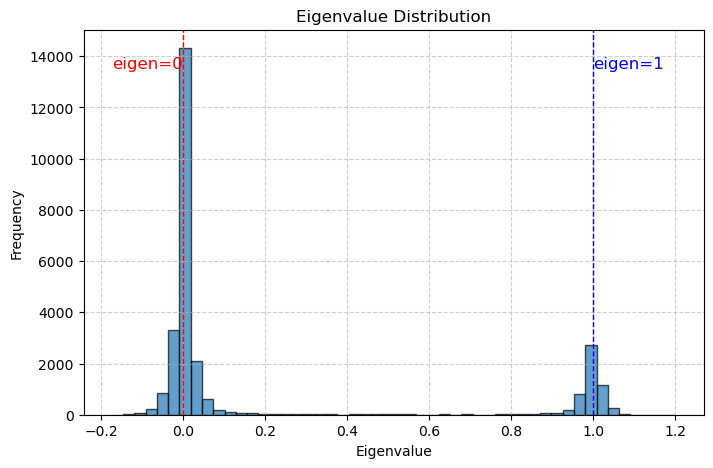

In [2]:
import matplotlib.pyplot as plt

def plot_distribution(eigenvalue_l, bins=50):
    plt.figure(figsize=(8, 5))
    plt.hist(eigenvalue_l, bins=bins, edgecolor='black', alpha=0.7)
    
    # Add vertical dashed lines
    plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
    plt.axvline(x=1, color='blue', linestyle='--', linewidth=1)
    
    # Add text labels
    plt.text(0, plt.ylim()[1] * 0.9, 'eigen=0', color='red', ha='right', fontsize=12)
    plt.text(1, plt.ylim()[1] * 0.9, 'eigen=1', color='blue', ha='left', fontsize=12)
    
    plt.xlabel('Eigenvalue')
    plt.ylabel('Frequency')
    plt.title('Eigenvalue Distribution')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Example usage
plot_distribution(eigenvalue_l)


In [3]:
from downfolding_methods_pytorch import nelec, norbs, fock_downfolding, Solve_fermionHam, perm_orca2pyscf
from pyscf import gto, scf, dft
import scipy

def calc_basisNN_inp_file(inp_data):
    elements = inp_data['elements']
    coordinates = inp_data['coordinates']
    atoms = [(elements[i], coordinates[i]) for i in range(len(elements))]
    S = gto.M(
        atom=atoms,  # Atomic symbols and coordinates
        basis="cc-pVDZ"
    ).intor("int1e_ovlp")
    sqrtS = scipy.linalg.sqrtm(S).real
    perm = perm_orca2pyscf(
        atom=atoms,  # Atomic symbols and coordinates
        basis="cc-pVDZ"
    )
    
    proj = inp_data['proj']
    proj = perm @ proj @ perm.T
    proj = sqrtS @ proj @ sqrtS
    
    n_fold = norbs(atom=atoms,basis='sto-3g')
    ham = fock_downfolding(n_fold,('self-defined',-proj),False,atom=atoms, basis='cc-pVDZ')
    E = Solve_fermionHam(ham.Ham_const, ham.int_1bd, ham.int_2bd, nele=nelec(atom=atoms, basis='sto-3G'), method='FCI')[0]
    return E

print(len(data["proj"]))


with tqdm(total=len(data["proj"]), desc="Processing", dynamic_ncols=True) as pbar:
    for proj, elements, pos in zip(data["proj"], data["elements"], data["pos"]):
        inp_data = {'elements': elements, 'coordinates': pos, 'proj': proj}
        basisNN_E = calc_basisNN_inp_file(inp_data)
        energy_data['basisNN'].append(basisNN_E)
        
        pbar.set_postfix({"basisNN_E": f"{basisNN_E:.6f}"})  # Format to 6 decimals for better readability
        pbar.update(1)

920


Processing: 100%|██████████| 920/920 [17:13<00:00,  1.12s/it, basisNN_E=-3.257879]


In [4]:
folder = "/global/homes/w/whe1/ML-LinearSpace/dataset/H6"
# collect other energies
for name in name_l:
    # Load the JSON file
    file_path = os.path.join(folder,'obs',name)
    with open(file_path, "r") as file:
        data = json.load(file)
    energy_data['opt'].append(data['opt_E'])
    energy_data['HF'].append(data['HF_E'])
    energy_data['B3LYP'].append(data['B3LYP_E'])
    energy_data['sto-3G'].append(data['sto-3G_E'])


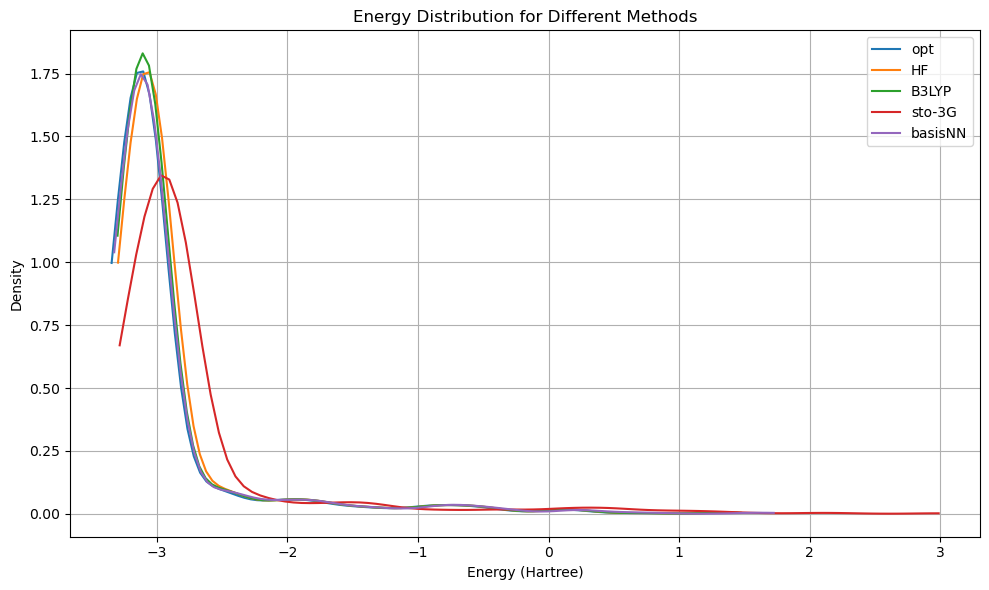

Figure saved as energy_distribution_smooth.png


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Assume `methods`, `energy_data`, and `name_l` are defined elsewhere
numeric_values = np.array([int(name.split('.')[0]) for name in name_l])
sorted_indices = np.argsort(numeric_values)

# Create figure
plt.figure(figsize=(10, 6))

# Plot KDE for each method
for method in methods:
    if energy_data[method]:  # Ensure there's data to plot
        energy_values = np.array(energy_data[method])[sorted_indices]

        # Perform KDE if enough data points exist
        if len(energy_values) > 1:
            kde = gaussian_kde(energy_values)
            x_range = np.linspace(min(energy_values), max(energy_values), 100)
            plt.plot(x_range, kde(x_range), label=method)

# Configure the plot
plt.title("Energy Distribution for Different Methods")
plt.xlabel("Energy (Hartree)")
plt.ylabel("Density")
plt.legend(loc="best")
plt.grid(True)

# Save and show the plot
output_file = "energy_distribution_smooth.png"
plt.tight_layout()
# plt.savefig(output_file, dpi=300)
plt.show()
plt.close()

print(f"Figure saved as {output_file}")
